In [1]:
import pandas as pd

from functions import join_stocks_crypto

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
import numpy as np

df_all_stocks = pd.read_csv('stocks_data_filled.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

cryptos_list = list(cryptos_df.columns)


log_returns = np.log(df_all_stocks / df_all_stocks.shift(1)).dropna()
daily_volatility = log_returns.std()
annual_volatility = daily_volatility * np.sqrt(252)

annual_volatility.sort_values().tail(20)

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


PRCT      0.692412
TTD       0.708151
3YU.F     0.747658
MDB       0.755362
SITM      0.765612
RNA       0.797502
AXSM      0.814172
DJT       0.901152
TBA.F     0.916075
ECX       0.923325
RYTM      0.941110
OL5.F     1.315230
SMMT      1.362448
4AH1.F    1.370364
2B5.F     1.385327
PJXC.F    1.894676
LPS1.F    3.012170
WK0.F     3.041260
0DH.F     4.547030
LFU2.F    4.970240
dtype: float64

In [3]:
# df_all_stocks = df_all_stocks.drop(columns=['OL5.F', 'SMMT', '4AH1.F', '2B5.F', 'PJXC.F', 'LPS1.F', 'WK0.F', '0DH.F', 'LFU2.F'])

# df_all_stocks.to_csv('stocks_data_filtered_volatility.csv')

# tickers = list(df_all_stocks.columns)

In [4]:
results = pd.read_csv('RESULTS.csv')
results.head(5)

,Distribution Model for Simulation/Out of Sample,Time Horizon,Portfolio Set,Original Portfolios,Reweighing Method,Cryptos,Clustering method,annualised_return,mean_period_return,sharpe_annualized,sharpe_period,VaR
0,bootstrap,126,rand_ports_equalw,Random Portfolios,equalw,Normal,No,0.196596,0.085792,0.985861,0.590735,1.464467
1,bootstrap,126,minvar_ports_equalw,Minimum Variance,equalw,Normal,No,0.205089,0.094679,1.890677,1.219287,0.761360
2,bootstrap,126,random_w_cryptos_random_equalw,Random Portfolios,equalw,Cryptos,random,0.180807,0.072819,0.650354,0.347314,2.027957
3,bootstrap,126,minvar_w_cryptos_random_equalw,Minimum Variance,equalw,Cryptos,random,0.185010,0.080180,0.881475,0.520775,1.532381
4,bootstrap,126,random_w_cryptos_kmeans_equalw,Random Portfolios,equalw,Cryptos,kmeans,0.380950,0.156830,1.455732,0.832285,2.166036


In [5]:
import os
folder = 'out_of_sample_direct_results/'
for file in os.listdir(folder):
    if '.xlsx' in file:
        df = pd.read_excel(folder + file, engine='openpyxl', sheet_name='annualised_return')

CLUSTERING INSIGHTS

In [ ]:

import yfinance as yf
import json

df_all_stocks = pd.read_csv('stocks_data_filtered_volatility.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
tickers_all = list(df_all_stocks.columns) + list(cryptos_df.columns) 



exchanges_dict = dict()
for ticker in tickers_all:
    dat = yf.Ticker(ticker)
    if ticker in list(cryptos_df.columns):
        exchanges_dict[ticker] = 'crypto'
    else:
        exchange = dat.info['exchange']
        exchanges_dict[ticker] = exchange


exchanges_dict

In [ ]:
with open('tickers_with_exchanges.json', 'w') as fp:
    json.dump(exchanges_dict, fp)


In [ ]:
cluster_labels = dict()
for method in ['ahc', 'kmeans', 'kshape']:
    with open(f'tickers_labels_{method}.json') as f:
        clusters = json.load(f)
        cluster_labels[method] = clusters


cluster_labels['ahc']


{'AAPL': 0,
 'ADBE': 9,
 'AMD': 9,
 'AMZN': 9,
 'ASML': 0,
 'AVGO': 9,
 'COST': 2,
 'CRESY': 2,
 'CSCO': 0,
 'ERIC': 2,
 'GOOGL': 9,
 'LIN': 0,
 'META': 9,
 'MSFT': 9,
 'NFLX': 0,
 'PEP': 3,
 'TMUS': 5,
 'TSLA': 9,
 'BCH': 4,
 'BSAC': 9,
 'CIB': 2,
 'EC': 2,
 'HDB': 4,
 'HMC': 0,
 'IBN': 0,
 'KEP': 8,
 'KT': 5,
 'LPL': 0,
 'PKX': 0,
 'SHG': 1,
 'SKM': 2,
 'SONY': 0,
 'TAK': 4,
 'TEO': 2,
 'TGS': 4,
 'TLK': 8,
 'TM': 2,
 'TSM': 0,
 'ADMA': 11,
 'APPF': 0,
 'AXSM': 11,
 'CRSP': 8,
 'DJT': 2,
 'ECX': 10,
 'ENPH': 10,
 'FRPT': 2,
 'IESC': 9,
 'LNTH': 10,
 'MDB': 9,
 'OLLI': 5,
 'PRCT': 5,
 'RDNT': 0,
 'RNA': 11,
 'RYTM': 0,
 'SITM': 9,
 'TTD': 0,
 'VERX': 0,
 'AI.PA': 9,
 'AIR.PA': 0,
 'BNP.PA': 0,
 'CS.PA': 0,
 'DG.PA': 0,
 'EL.PA': 0,
 'MC.PA': 3,
 'OR.PA': 0,
 'RMS.PA': 3,
 'SAF.PA': 0,
 'SAN.PA': 8,
 'SGO.PA': 9,
 'SU.PA': 0,
 'TTE.PA': 1,
 '3YU.F': 10,
 '8GC.F': 1,
 'BPE.F': 11,
 'BPE5.F': 11,
 'BSD2.F': 9,
 'BY6.F': 8,
 'KM6.F': 8,
 'PQ9.F': 7,
 'QF9.F': 6,
 'SKFA.F': 8,
 'TBA.F': 7,

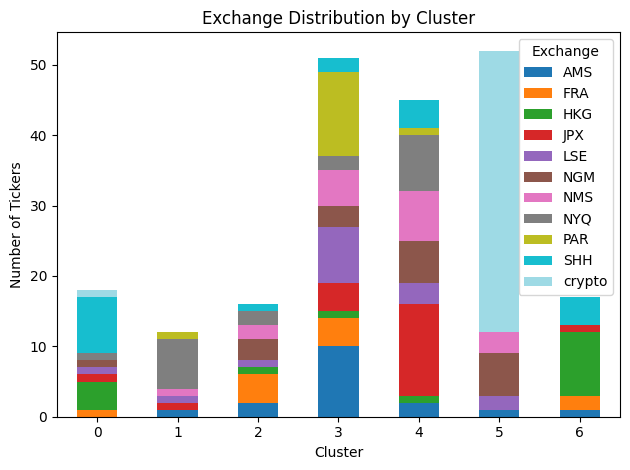

In [19]:
import matplotlib.pyplot as plt

# Example dictionaries
ticker_to_exchange = exchanges_dict
ticker_to_cluster = cluster_labels['kshape']


# Merge into a DataFrame
df = pd.DataFrame({
    'Ticker': list(ticker_to_exchange.keys()),
    'Exchange': [ticker_to_exchange[t] for t in ticker_to_exchange],
    'Cluster': [ticker_to_cluster[t] for t in ticker_to_exchange]
})

# Count values
pivot = df.groupby(['Cluster', 'Exchange']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Exchange Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Tickers')
plt.xticks(rotation=0)
plt.legend(title='Exchange')
plt.tight_layout()
plt.show()

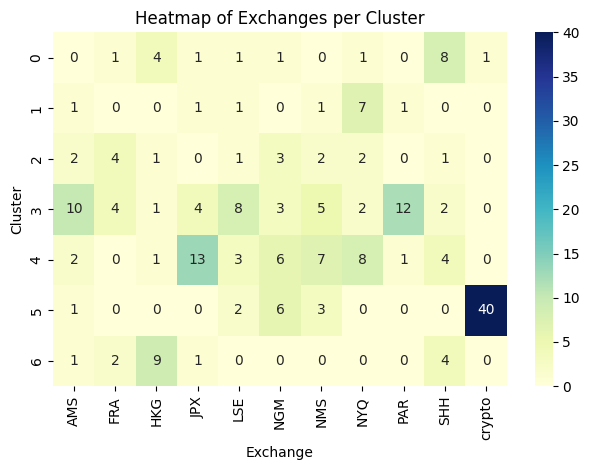

In [20]:
import seaborn as sns

# Reuse the `pivot` DataFrame from above
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Exchanges per Cluster')
plt.xlabel('Exchange')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

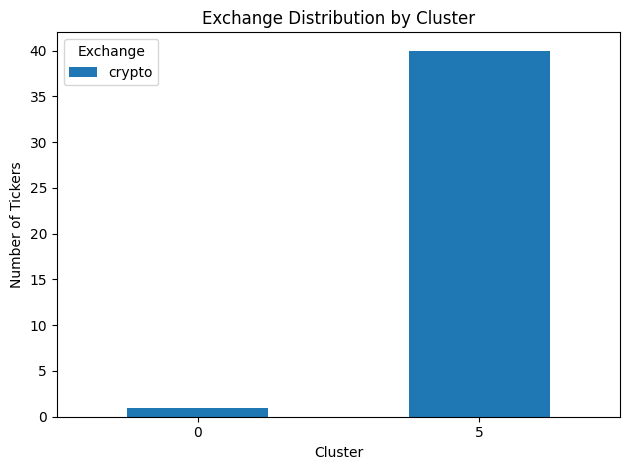

In [27]:
# Filter to one exchange
exchange_filter = 'crypto'
df_filtered = df[df['Exchange'] == exchange_filter]

pivot = df_filtered.groupby(['Cluster', 'Exchange']).size().unstack(fill_value=0)

# Plot
pivot.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Exchange Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Tickers')
plt.xticks(rotation=0)
plt.legend(title='Exchange')
plt.tight_layout()
plt.show()

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning:

invalid value encountered in log



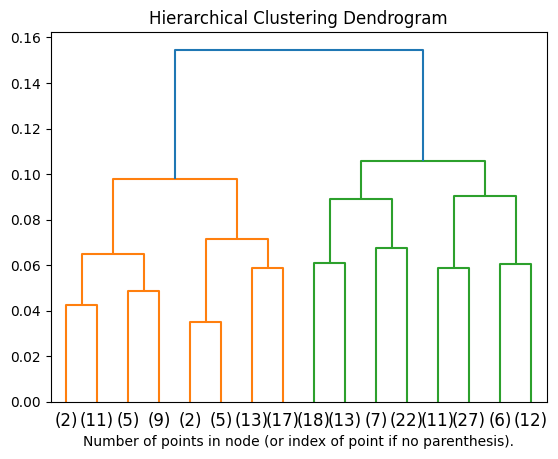

In [43]:
#DO A DENDROGRAM


from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



df_all_stocks = pd.read_csv('stocks_data_new.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

joined_df.index = pd.to_datetime(joined_df.index)
joined_df_3days = joined_df.resample('3D').last()

df_returns = np.log(joined_df_3days / joined_df_3days.shift(1)).dropna()

df = df_returns.rolling(window=60, center=True).mean().dropna()
#labels, tickers_with_labels_ahc, _, _ = run_clustering_model(df, n_clus=12, model_name='ahc', linkage='complete', return_mode='geometric', n_init=3)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(df)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()